In [1]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec

In [2]:
w2v_model = Word2Vec.load('./food.model')

In [3]:
import math
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)

In [4]:
train_df = pd.read_csv('./train_data.tsv',sep='\t')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20010 entries, 0 to 20009
Data columns (total 5 columns):
일자      20010 non-null int64
time    20010 non-null object
식사내용    20010 non-null object
매출일자    20010 non-null float64
수량      20010 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 781.7+ KB


In [5]:
time_dummy = pd.get_dummies(train_df['time'])

In [6]:
train_df = pd.concat([train_df, time_dummy],axis=1)

In [7]:
num_values = 7
degrees_week = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_week)
sin_week = np.sin(np.deg2rad(degrees_week))
print(sin_week)
cos_week = np.cos(np.deg2rad(degrees_week))
print(cos_week)

num_values = 12
degrees_month = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_month)
sin_month = np.sin(np.deg2rad(degrees_month))
print(sin_month)
cos_month = np.cos(np.deg2rad(degrees_month))
print(cos_month)

num_values = 31
degrees_day = np.linspace(0, 360, num_values + 1)[:-1]
print(degrees_day)
sin_day = np.sin(np.deg2rad(degrees_day))
print(sin_day)
cos_day = np.cos(np.deg2rad(degrees_day))
print(cos_day)

[   0.           51.42857143  102.85714286  154.28571429  205.71428571
  257.14285714  308.57142857]
[ 0.          0.78183148  0.97492791  0.43388374 -0.43388374 -0.97492791
 -0.78183148]
[ 1.          0.6234898  -0.22252093 -0.90096887 -0.90096887 -0.22252093
  0.6234898 ]
[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.]
[  0.00000000e+00   5.00000000e-01   8.66025404e-01   1.00000000e+00
   8.66025404e-01   5.00000000e-01   1.22464680e-16  -5.00000000e-01
  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01  -5.00000000e-01]
[  1.00000000e+00   8.66025404e-01   5.00000000e-01   6.12323400e-17
  -5.00000000e-01  -8.66025404e-01  -1.00000000e+00  -8.66025404e-01
  -5.00000000e-01  -1.83697020e-16   5.00000000e-01   8.66025404e-01]
[   0.           11.61290323   23.22580645   34.83870968   46.4516129
   58.06451613   69.67741935   81.29032258   92.90322581  104.51612903
  116.12903226  127.74193548  139.35483871  150.96774194  162.58064516
  174.19354839  185.806

In [8]:
def make_coord(date,num_class):
    # 1 ~ 12, 1 ~ 7, 1 ~ 31
    degrees = np.linspace(0,360,num_values + 1)[:-1]
    sin = np.sin(np.deg2rad(degrees))
    cos = np.cos(np.deg2rad(degrees))
    return sin, cos


def date2coord(date, sin, cos):
    return cos[date-1], sin[date-1]


def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:])
    day = datetime(y, m, d)
    return day.weekday()

### aux feature

In [9]:
train_df['month'] = train_df['일자'].apply(lambda x:int(str(x)[4:6]))
train_df['day'] = train_df['일자'].apply(lambda x:int(str(x)[6:]))
train_df['week'] = train_df['일자'].apply(date2week)
train_df['week'] = train_df['week'] + 1 

In [10]:
train_df['day_coord'] = train_df['day'].apply(date2coord, args=(sin_day, cos_day,))
train_df['month_coord'] = train_df['month'].apply(date2coord, args=(sin_month, cos_month))
train_df['week_coord'] = train_df['week'].apply(date2coord, args=(sin_week, cos_week,))

In [11]:
x_list = []

In [12]:
X_arr = np.array(train_df['day_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [13]:
X_arr = np.array(train_df['month_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [14]:
X_arr = np.array(train_df['week_coord'].apply(lambda x:np.array(x)).tolist())
x_list.append(X_arr)

In [15]:
X_arr = train_df['아침'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['점심2'].values.reshape(-1,1)
x_list.append(X_arr)
X_arr = train_df['저녁'].values.reshape(-1,1)
x_list.append(X_arr)

### cnn feature

In [16]:
train_df['split_content'] = train_df['식사내용'].apply(lambda x: x[:-1].split(','))
train_df['content_len'] = train_df['split_content'].apply(lambda x: len(x))

In [17]:
s = train_df['content_len'].value_counts()
s

7     6319
8     3799
6     3576
16    1770
10    1040
14     730
5      503
9      483
15     364
13     354
12     325
17     278
11     277
4       91
18      66
19      19
3       10
20       3
2        1
23       1
1        1
Name: content_len, dtype: int64

In [18]:
train_df['padded_content'] = train_df['split_content'].apply(lambda x: x + ['<PAD>']*(24 - len(x)))

In [19]:
train_df['padded_content'].head()

0    [과일샐러드, 닭죽, 돈육마늘장조림, 떡만두국, 부추김무침, 쌀밥, 딸기잼(중), ...
1    [감자으깸샐러드, 비프까스, 스위트피클, 쌀밥, 옥수수스프, <PAD>, <PAD>...
2    [골뱅이야채무침, 새우맛살튀김, 쌀밥(사무직), 열무겉절이, 칼국수, <PAD>, ...
3    [계란죽, 곤약멸치조림, 김치국, 마카로니샐러드, 쌀밥, 오징어회무침, 딸기잼(중)...
4    [계란탕, 단무지잔파무침, 자장소스, 잡채밥, 탕수만두, <PAD>, <PAD>, ...
Name: padded_content, dtype: object

In [20]:
def foodlist2wordmat(x):
    return w2v_model.wv[x]

In [21]:
foodlist2wordmat(train_df.iloc[0]['padded_content']).shape

(24, 100)

In [22]:
X_train = np.array(train_df['padded_content'].apply(foodlist2wordmat).tolist()).reshape(len(train_df),24,100,1)

In [23]:
y_train = train_df['수량'].values.reshape(-1,1)

In [24]:
print(X_train.shape, y_train.shape)

(20010, 24, 100, 1) (20010, 1)


In [25]:
import keras

Using TensorFlow backend.


In [26]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input

In [45]:
def base_cnn_model():
    visible = Input(shape=(24,100,1))
    conv1 = Conv2D(16,kernel_size=4, activation='relu')(visible)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(8, kernel_size=4, activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flat2 = Flatten()(pool2)
    hidden1 = Dense(128, activation='relu')(flat2)
    output = Dense(1, activation='sigmoid')(hidden1)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()
    return model

In [46]:
cnn_model = base_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 24, 100, 1)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 97, 16)        272       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 48, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 45, 8)          2056      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 22, 8)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 528)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               67712     
__________

In [48]:
cnn_model.fit(x=X_train,y=y_train,batch_size=100,epochs=3)

Epoch 1/3
20010/20010 [==============================] - 17s 863us/step - loss: 648.6376
Epoch 2/3
20010/20010 [==============================] - 17s 866us/step - loss: 648.6376
Epoch 3/3
20010/20010 [==============================] - 18s 883us/step - loss: 648.6376


In [49]:
cnn_model.predict(X_train[0].reshape(1,24,100,1)), y_train[0]

(array([[ 1.]], dtype=float32), array([ 37.47292419]))

In [50]:
pred = cnn_model.predict(X_train[:100])
y_test = y_train[:100]

/Users/1003874/anaconda/envs/gcp-vision/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


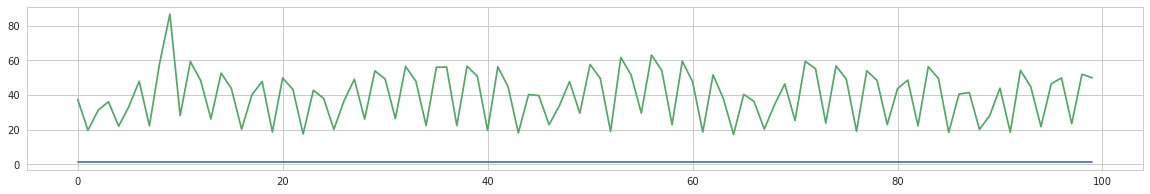

In [51]:
plt.plot(pred[:100])
plt.plot(y_test[:100])